# Botanical research
## Build a classifier capable of determining a plant's species from a photo.

In [362]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from zipfile import ZipFile

In [148]:
import tensorflow as tf
tf.random.set_seed(1)

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Extracting the images from the zip file

In [3]:
from zipfile import ZipFile

with ZipFile('Dataset - Plant-seedlings-classification.zip', 'r') as file:
    file.extractall('Dataset')

### Checking the size of random images from each folder

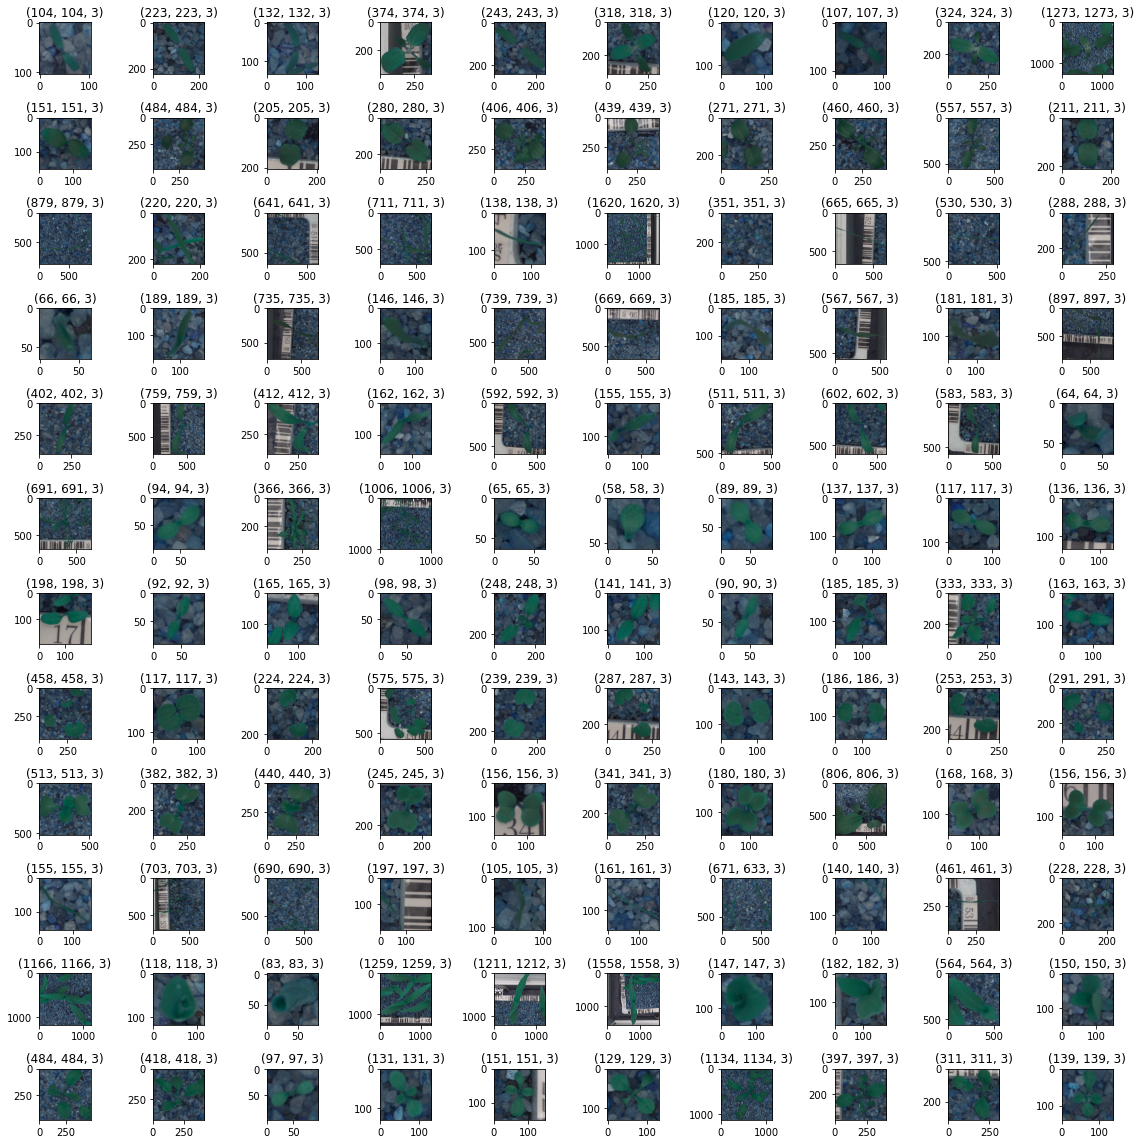

In [4]:
rows = len(os.listdir('Dataset/train/'))
columns = 10

fig = plt.figure(figsize=(16, 16))
index = 0

for i in os.listdir('Dataset/train/'):    
    for j in range(1, 11):
        index += 1
        img_path = random.choice([
            x for x in os.listdir('Dataset/train/' + i)
            if os.path.isfile(os.path.join('Dataset/train/{}'.format(i), x))
        ])
        img = cv2.imread(os.path.join('Dataset/train/{}'.format(i), img_path))
        ax = fig.add_subplot(rows, columns, index, title=format(img.shape))
        plt.imshow(img)

fig.tight_layout()
plt.show()

#### Observations:
1. It can be observed that the images are of different size
2. The images are colored images hence 3 channels present.
3. Hence while importing, we are going to resize the images so all images will be of same dimensions.
4. Also, the background is similar in the images and can be easily distinguished from the plant so we will extract the plant from the background. 

In [5]:
def extract_plant(img):
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    return clear

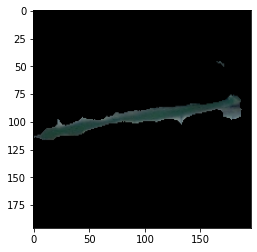

In [6]:
image = cv2.imread('Dataset/train/Black-grass/0050f38b3.png')
clear_img = extract_plant(image)
plt.imshow(clear_img)

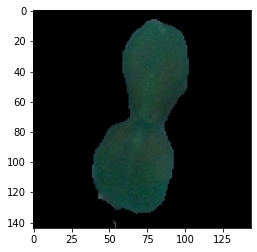

In [7]:
image = cv2.imread('Dataset/train/Cleavers/005b4a3e3.png')
clear_img = extract_plant(image)
plt.imshow(clear_img)

#### Observations:
As it can observed, the plant has been masked out properly from the background. 

### Creating the dataset

In [8]:
X = list()
y = list()

for i in os.listdir('Dataset/train/'):
    for j in os.listdir('Dataset/train/' + i):
        img = cv2.imread('Dataset/train/{}/{}'.format(i, j))
        img = extract_plant(img)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(i)

In [9]:
X = np.asarray(X)
y = np.asarray(y)

In [10]:
print('The shape of input dataset {}'.format(X.shape))

The shape of input dataset (4750, 128, 128, 3)


In [11]:
np.array(np.unique(y, return_counts=True)).T

array([['Black-grass', '263'],
       ['Charlock', '390'],
       ['Cleavers', '287'],
       ['Common Chickweed', '611'],
       ['Common wheat', '221'],
       ['Fat Hen', '475'],
       ['Loose Silky-bent', '654'],
       ['Maize', '221'],
       ['Scentless Mayweed', '516'],
       ['Shepherds Purse', '231'],
       ['Small-flowered Cranesbill', '496'],
       ['Sugar beet', '385']], dtype='<U25')

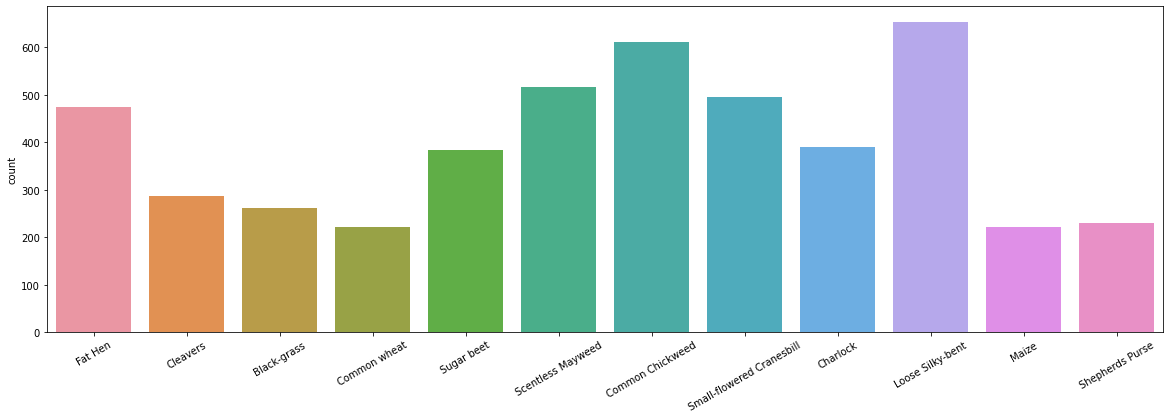

In [12]:
plt.figure(figsize=(20, 6))
sns.countplot(y)
plt.xticks(rotation=30)
plt.show()

#### Observations:
1. There are total of 4750 images available. 
2. It can be clearly seen that there is class imbalanced problem with the provided dataset.
3. The maximum images are available for 'Loose Silky-bent' followed by 'Common Chickweed' both having more than 600 images while the minimum images are available for 'Maize' and 'Common wheat' having only 221 images.
4. Currently we are not generating more images to treat class imbalanced problem, we will moving forward with the data provided.

### Shuffling the data and labels

In [13]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=1)

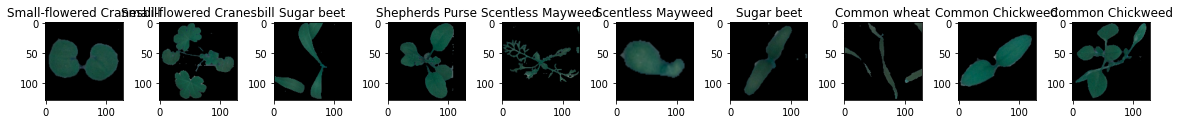

In [14]:
fig = plt.figure(figsize=(16, 16))
columns = 10
rows = 1
for i in range(1, columns*rows+1):
    img = X[i]
    ax = fig.add_subplot(rows, columns, i, title=str(y[i]))
    plt.imshow(img)

fig.tight_layout()
plt.show()

#### Observations:
1. We have shuffled the data and its label randomly.
2. It can verified in visualization, the respective label and corresponding image has been mapped properly.

In [39]:
#### Converting labels into numeric

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(y)

### Splitting the data into training and testing

In [263]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of training dataset: {}'.format(X_train.shape))
print('Shape of testing dataset: {}'.format(X_test.shape))

Shape of training dataset: (3562, 128, 128, 3)
Shape of testing dataset: (1188, 128, 128, 3)


### Normalizing the data

In [264]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

## Classifier model using supervised learning

As the dataset is in 4 dimension, in order to train supervised learning algorithsm, the dataset needs to be converted into 2 dimension. The steps we will doing:
1. Convert the images into grayscale
2. Flatten the grayscaled numpy array
3. Applying PCA to reduce the dimensions
4. Fit the dataset into multiple supervised algorithms and find out the best score trained model
5. Tune the hyperparameters of the best model to get best accuracy.

### Converting image into grayscale and flattening

In [17]:
def convert_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.flatten()
    return img_gray

In [18]:
X_train_converted = np.array([convert_image(x) for x in X_train])
X_test_converted = np.array([convert_image(x) for x in X_test])

In [19]:
print('The shape of converted X_train:', X_train_converted.shape)
print('The shape of converted X_test:', X_test_converted.shape)

(3562, 16384)
(1188, 16384)


### Applying PCA to reduce dimensions

Here, n_components=0.90 means it will return the Eigenvectors that have the 90% of the variation in the dataset.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)

X_train_pca = pca.fit_transform(X_train_converted)
X_test_pca = pca.transform(X_test_converted)

### Identifying the best model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [22]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('XGB', XGBClassifier(eval_metric='logloss')))

In [23]:
results = list()
names = list()

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_pca, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR : 0.412689 (0.015365)
KNN : 0.528910 (0.017918)
DT : 0.366083 (0.024206)
RF : 0.478100 (0.025561)
SVC : 0.644864 (0.018815)
XGB : 0.551094 (0.015605)


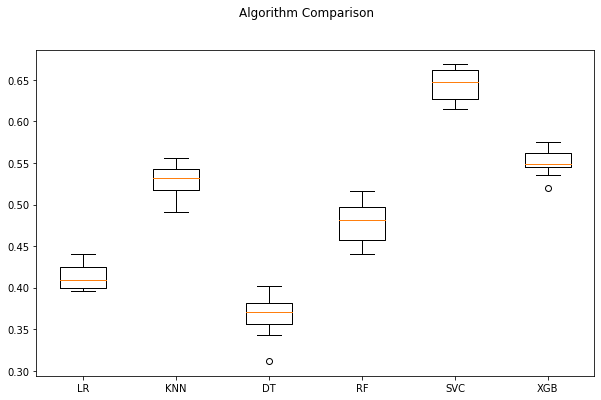

In [24]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observations:
Based on the above plot, we can verify SVC is performing better with comparison among the other algorithms. So we will choose SVC for model and do hyper parameter tuning to further improve the accuracy.

### Hyper parameter tuning

In [25]:
estimator = SVC()
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0], 
    'gamma': ['scale', 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

kfold = KFold(n_splits=10)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold)

grid_result = grid.fit(X_train_pca, y_train)

In [26]:
print('The best params: %s' % grid_result.best_params_)
print('The best score: %s' % grid_result.best_score_)

The best params: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
The best score: 0.6600234475812797


#### Observations:
1. We have tuned the parameter of SVC model and printed out the best params.
2. The score has been slightly improved after hyperparameter tuning.

## Classifier model using Neural Networks

The steps we will doing:
1. Preprocess the input and output for fitting into neural networks
2. Finalize the architecture of the network
3. Tuning the hyper parameters to get best accuracy

In [182]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Processing training and testing data

In [183]:
X_train_gray = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_train])
X_test_gray = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_test])

In [184]:
print('The shape of gray scaled X_train:', X_train_gray.shape)
print('The shape of gray scaled X_test:', X_test_gray.shape)

The shape of gray scaled X_train: (3562, 128, 128)
The shape of gray scaled X_test: (1188, 128, 128)


In [268]:
y_train_nn = to_categorical(y_train, num_classes=12)
y_test_nn = to_categorical(y_test, num_classes=12)

In [186]:
X_train_gray = X_train_gray.reshape(3562, 16384)
X_test_gray = X_test_gray.reshape(1188, 16384)

In [196]:
def create_nn_model(layers, optimizer, loss, metrics, epochs, batch_size):
    model = Sequential()
    
    for layer in layers:
        model.add(layer)  
    
    print(model.summary())

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    ]

    history = model.fit(X_train_gray, y_train_nn, validation_data=(X_test_gray, y_test_nn), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    print('_' * 100)
    print('\n')
    print('Plots of training and validation loss and accuracy \n')

    fig = plt.figure(figsize=(16, 6))
    fig.add_subplot(1, 2, 1, title='Training and Validation loss')
    plt.plot(history.epoch, history.history['loss'])
    plt.plot(history.epoch, history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])

    fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
    plt.plot(history.epoch, history.history['accuracy'])
    plt.plot(history.epoch, history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()
    plt.close()
    
    print('_' * 100)
    
    print('\n')
    print('Best Accuracy')
    print('accuracy:', np.max(history.history['accuracy']))
    print('\n')
    print('Evaluating the score on the testing data')
    print('Score:', model.evaluate(X_test_gray, y_test_nn))

    return history, model

### Defining the architecture of neural network

<b>Iteration 1</b>: train a base neural network

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_451 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_452 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_453 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_454 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_455 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_456 (Dense)            (None, 12)                6156      
Total params: 705,516
Trainable params: 705,516
Non-trainable params: 0
_______________________________________________

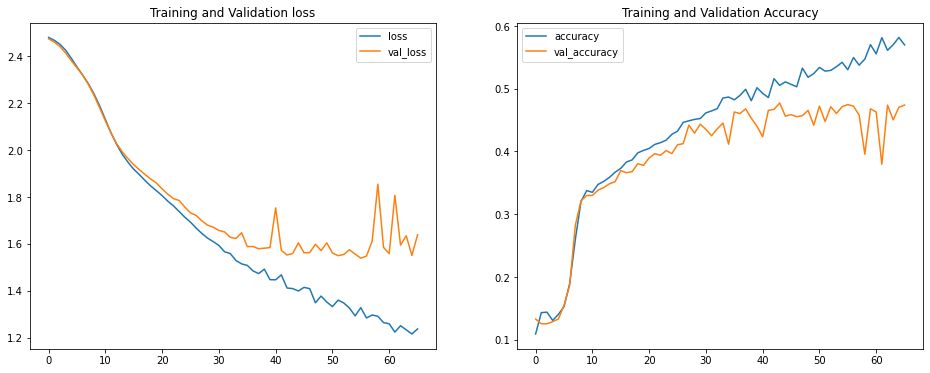

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.5816956758499146


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.6386 - accuracy: 0.4739
Score: [1.63858163356781, 0.4739057123661041]


In [197]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_nn_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
The best accuracy is ony around 55%. In next step, we will try to add more dense layers and check whether we can get better accuracy.

___

<b>Iteration 2:</b> Increasing the dense layers

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_457 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_458 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_459 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_460 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_461 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_462 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_463 (Dense)            (None, 256)             

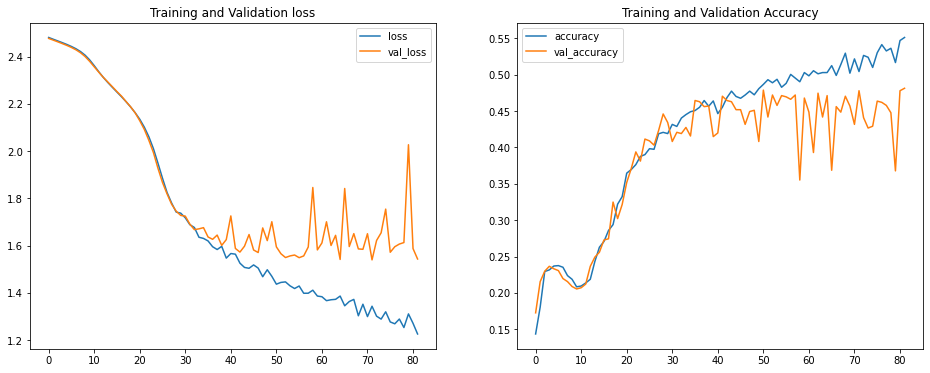

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.5513756275177002


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.5435 - accuracy: 0.4815
Score: [1.5434949398040771, 0.48148149251937866]


In [198]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_nn_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
The accuracy has been decreased, hence we can finalize the number of dense layer from iteration 1. We will add dropout and batch normalization layer in next step to improve the accuracy.

___

<b>Iteration 3:</b> Adding Dropout and BatchNormalization layer

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_467 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_468 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_104 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_469 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_60 (Batc (None, 128)               512       
_________________________________________________________________
dense_470 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_105 (Dropout)        (None, 256)             

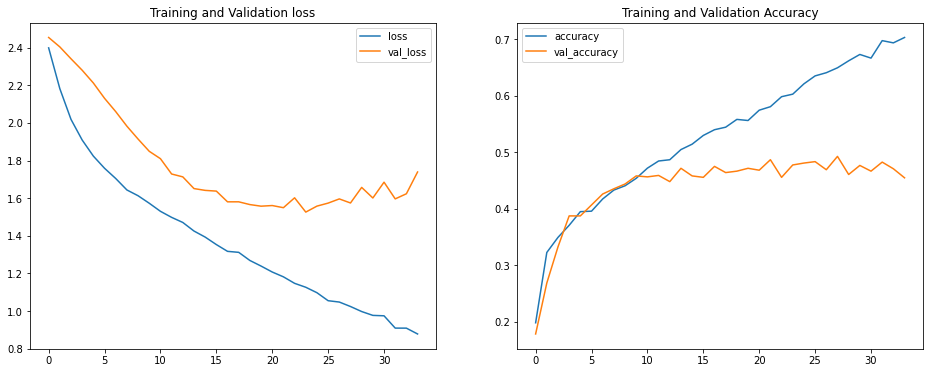

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.7026951313018799


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.7390 - accuracy: 0.4545
Score: [1.7389789819717407, 0.4545454680919647]


In [199]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_nn_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
The accuracy has been improved but evaluation accuracy is very low, hence the model is currently overfitting. In next iteration, we will use adam as optimizer and check for overfitting and accuracy improvements. 
___

<b>Iteration 4:</b> Using adam as an optimizer

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_473 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_474 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_106 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_475 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_61 (Batc (None, 128)               512       
_________________________________________________________________
dense_476 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_107 (Dropout)        (None, 256)             

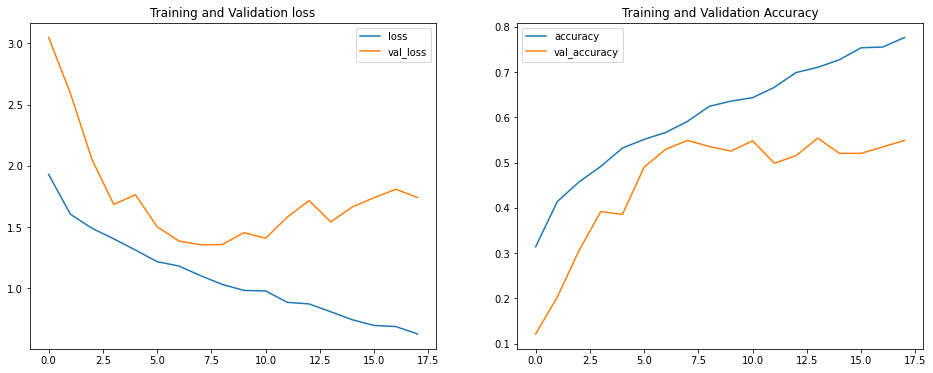

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.7762492895126343


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.7411 - accuracy: 0.5488
Score: [1.7410860061645508, 0.5488215684890747]


In [200]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_nn_model(layers, 'adam', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
Although the training accuracy has improved but the model is still overfitting. In next step, we will tune the adam optimizer parameter to check for improvment in the accuracy.
___

<b>Iteration 5:</b> Tuning the parameter for adam optimizer 

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_551 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_552 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_132 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_553 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_74 (Batc (None, 128)               512       
_________________________________________________________________
dense_554 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_133 (Dropout)        (None, 256)             

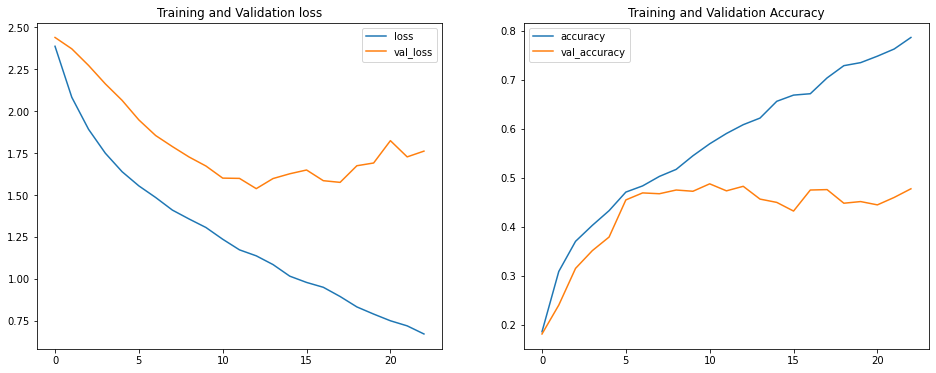

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.786075234413147


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.7618 - accuracy: 0.4773
Score: [1.7618144750595093, 0.47727271914482117]


In [213]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

adam = Adam(learning_rate=0.0001, amsgrad=True)
history, model = create_nn_model(layers, adam, 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
In this iteration, there is not much improvement neither for training accuracy nor for validation accuracy. In next step, we will try to tune the layers parameters and check for improvement in accuracy.

<b>Iteration 6:</b> Tuning the parameter for the layers 

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_587 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_588 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_144 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_589 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_80 (Batc (None, 128)               512       
_________________________________________________________________
dense_590 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_145 (Dropout)        (None, 256)             

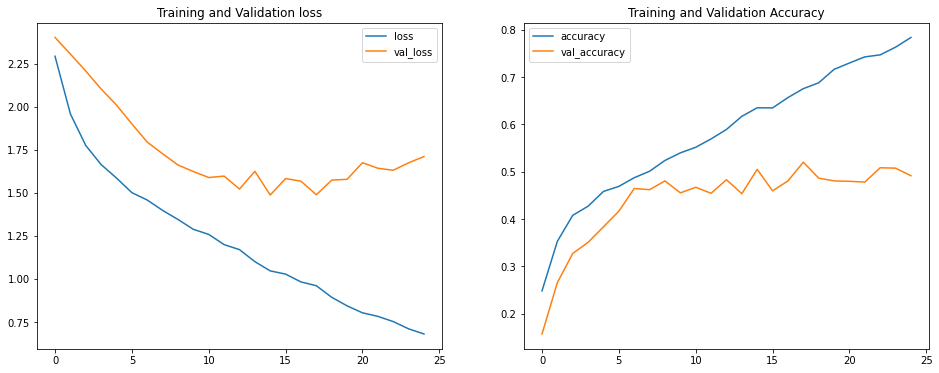

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.7835485935211182


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.7109 - accuracy: 0.4916
Score: [1.7108702659606934, 0.4915824830532074]


In [219]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

adam = Adam(learning_rate=0.0001, amsgrad=True)
history, model = create_nn_model(layers, adam, 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
There is no significant change in accuracy and validation accuracy. In next step, we will decrease the batch_size to check for any improvments.

<b>Iteration 7:</b> Decreasing the batch size

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_599 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_600 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_148 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_601 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_82 (Batc (None, 128)               512       
_________________________________________________________________
dense_602 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_149 (Dropout)        (None, 256)             

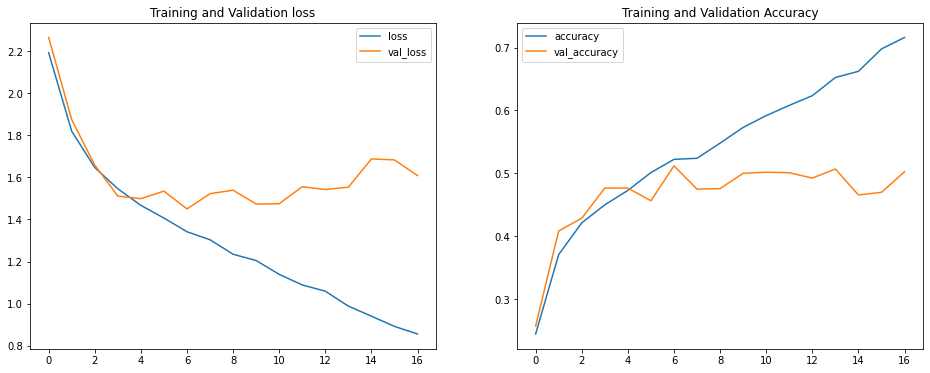

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.7161706686019897


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.6082 - accuracy: 0.5025
Score: [1.6082407236099243, 0.502525269985199]


In [221]:
layers = [
    Dense(32, input_shape=(16384,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

adam = Adam(learning_rate=0.0001, amsgrad=True)
history, model = create_nn_model(layers, adam, 'categorical_crossentropy', ['accuracy'], 100, 32)

#### Observations:
Although there has been slight increase in validation acccuracy but there is drop also happened in training accuracy. 

<b>Iteration 8:</b> Updating the architecture and tuning the layer parameters by keeping other parameters constants

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_652 (Dense)            (None, 32)                524320    
_________________________________________________________________
dense_653 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_654 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_168 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_655 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_88 (Batc (None, 256)               1024      
_________________________________________________________________
dense_656 (Dense)            (None, 256)             

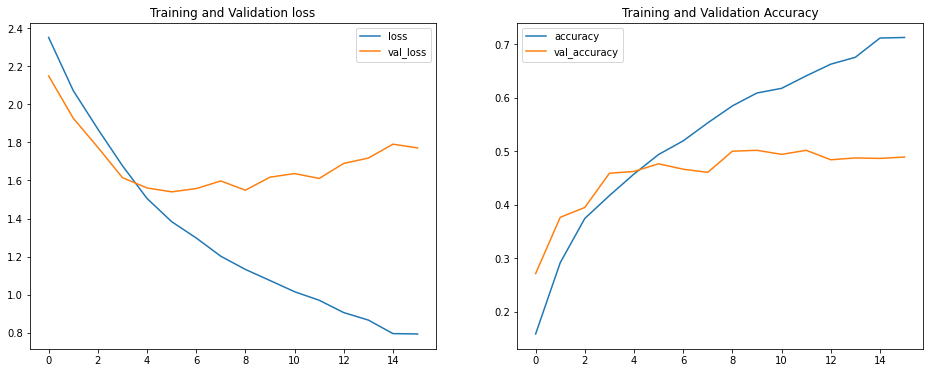

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.7128018140792847


Evaluating the score on the testing data
38/38 [==============================] - 0s 2ms/step - loss: 1.7710 - accuracy: 0.4891
Score: [1.7710270881652832, 0.4890572428703308]


In [229]:
layers = [
    Dense(32, input_shape=(16384,), activation='relu'),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(trainable=False),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dense(12, activation='softmax')
]

adam = Adam(learning_rate=0.0001, amsgrad=True)
history, model = create_nn_model(layers, adam, 'categorical_crossentropy', ['accuracy'], 100, 32)

#### Observations:
Even after several iteration, the validation accuracy is not improving. This might be due to the imbalanced data split. Currently we are not modifying the train and test data, so we will go ahead with the best accuracy model which we got in Iteration 5.
___

## Classifier model using Convolutional Neural Networks

The steps we will doing:
1. Build a convolutional neural network
2. Tuning the hyper parameters to get best accuracy

In [253]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D, Flatten, InputLayer

In [259]:
print('The shape of X_train:', X_train.shape)
print('The shape of X_test:', X_test.shape)

The shape of X_train: (3562, 128, 128, 3)
The shape of X_test: (1188, 128, 128, 3)


In [269]:
y_train_cnn = to_categorical(y_train, num_classes=12)
y_test_cnn = to_categorical(y_test, num_classes=12)

In [291]:
def create_cnn_model(layers, optimizer, loss, metrics, epochs, batch_size):
    model = Sequential()
    
    for layer in layers:
        model.add(layer)
    
    print(model.summary())

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    ]

    history = model.fit(X_train, y_train_cnn, validation_data=(X_test, y_test_cnn), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    print('_' * 100)
    print('\n')
    print('Plots of training and validation loss and accuracy \n')

    fig = plt.figure(figsize=(16, 6))
    fig.add_subplot(1, 2, 1, title='Training and Validation loss')
    plt.plot(history.epoch, history.history['loss'])
    plt.plot(history.epoch, history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])

    fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
    plt.plot(history.epoch, history.history['accuracy'])
    plt.plot(history.epoch, history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()
    plt.close()
    
    print('_' * 100)
    
    print('\n')
    print('Best Accuracy')
    print('accuracy:', np.max(history.history['accuracy']))
    print('\n')
    print('Evaluating the score on the testing data')
    print('Score:', model.evaluate(X_test, y_test_cnn))

    return history, model

<b>Iteration 1:</b> Training a basic CNN with Conv2D, Flatten and Dense layers

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 122, 122, 64)      51264     
_________________________________________________________________
flatten_22 (Flatten)         (None, 952576)            0         
_________________________________________________________________
dense_709 (Dense)            (None, 128)               121929856 
_________________________________________________________________
dense_710 (Dense)            (None, 12)                1548      
Total params: 121,983,564
Trainable params: 121,983,564
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
28/28 [==============================] - 204s 7s/step - loss: 3.5139 - accuracy: 0.1275

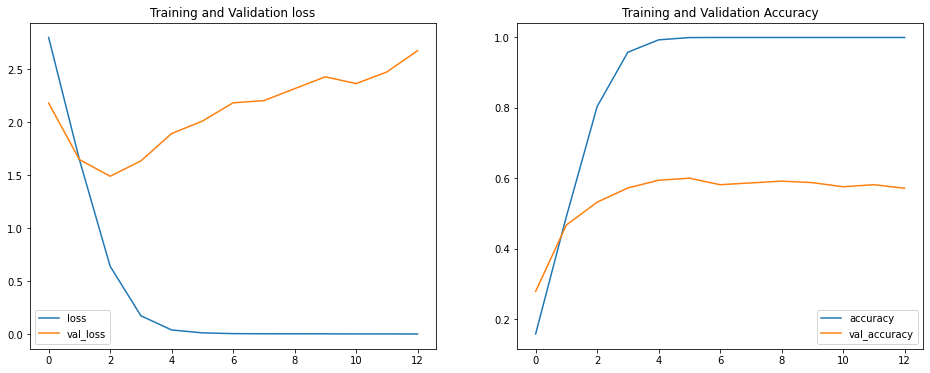

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.9997192621231079


Evaluating the score on the testing data
38/38 [==============================] - 15s 386ms/step - loss: 2.6762 - accuracy: 0.5715
Score: [2.6761720180511475, 0.5715488195419312]


In [292]:
layers = [
    Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation='relu'),
    Conv2D(64, kernel_size=(5, 5), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_cnn_model(layers, 'adam', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
As it can be seen the trained model is completely overfitting. In next iteration, we will add MaxPooling2D, BatchNormalization and Dropout layers to avoid overfitting.
___

<b>Iteration 2:</b> Adding MaxPooling2D and Dropout layers.

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_109 (Bat (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 59, 59, 64)        51264     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_180 (Dropout)        (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 53824)          

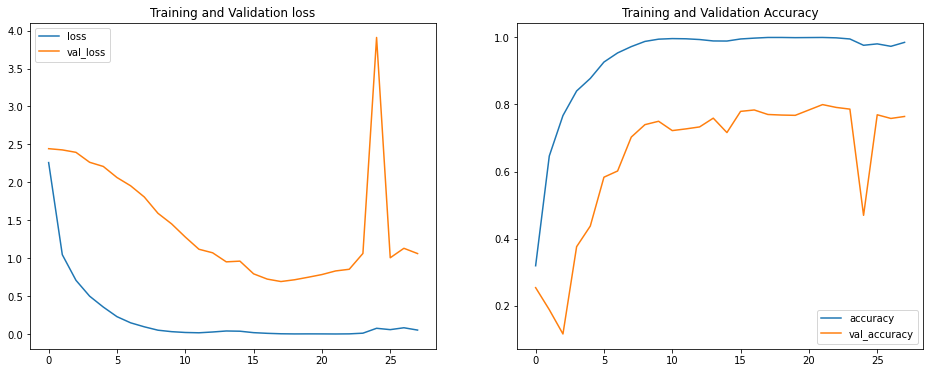

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.9997192621231079


Evaluating the score on the testing data
38/38 [==============================] - 5s 138ms/step - loss: 1.0613 - accuracy: 0.7643
Score: [1.0613075494766235, 0.7643097639083862]


In [293]:
layers = [
    Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_cnn_model(layers, 'adam', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
Still the model is overfitting even after adding MaxPooling2D, BatchNormalization ad Dropout layer. We need to try adding more Conv2D and Dense layers and update the architecture to avoid overfitting.

<b>Iteration 3:</b> Modifying the architecture

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_110 (Bat (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 61, 61, 128)       36992     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
batch_normalization_111 (Bat (None, 30, 30, 128)       512       
_________________________________________________________________
dropout_181 (Dropout)        (None, 30, 30, 128)    

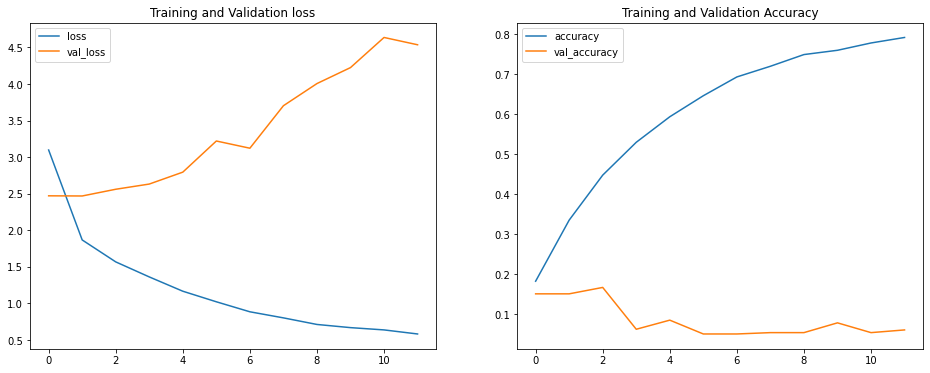

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.7914093136787415


Evaluating the score on the testing data
38/38 [==============================] - 7s 192ms/step - loss: 4.5361 - accuracy: 0.0614
Score: [4.5360870361328125, 0.061447810381650925]


In [294]:
layers = [
    Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.5),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalMaxPool2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_cnn_model(layers, 'adam', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
After modifying the architecture, added more layer, the accuracy has been drastically dropped. The earlier architecture is performing better but not giving the good testing accuracy.

<b>Iteration 4:</b> Changing the optimizer from Adam to SGD.

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_112 (Bat (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 59, 59, 64)        51264     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_183 (Dropout)        (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 53824)          

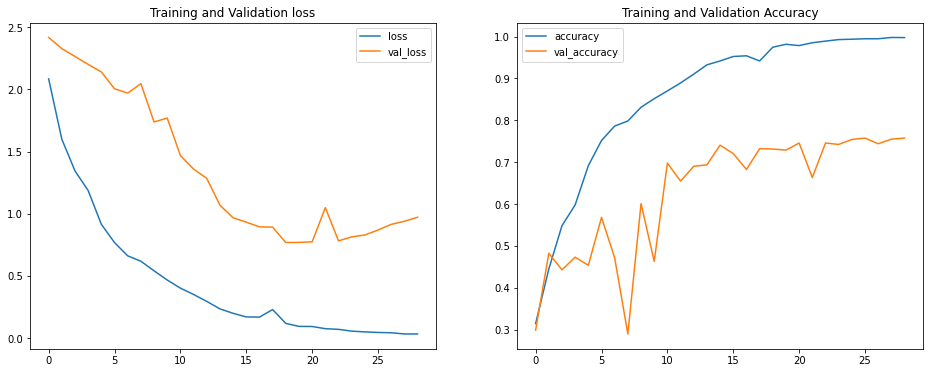

____________________________________________________________________________________________________


Best Accuracy
accuracy: 0.9980348348617554


Evaluating the score on the testing data
38/38 [==============================] - 4s 117ms/step - loss: 0.9714 - accuracy: 0.7576
Score: [0.9713506698608398, 0.7575757503509521]


In [295]:
layers = [
    Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(12, activation='softmax')
]

history, model = create_cnn_model(layers, 'sgd', 'categorical_crossentropy', ['accuracy'], 100, 128)

#### Observations:
Even after changing the optimizer, still we are getting overfitting issue. Hence we will select the Iteration 2 model where we have achieved the highest accuracy.

## Comaparison between SVC, DNN and CNN models 

In earlier steps, we have built and finalized the models with tuning the parameters, let build the models and compare the accuracy and results.

<b>Note:</b> For each model, we have created different train and test dataset, hence we will using those datasets for training and testing the models.

___
#### Supervised Learning Model

In [296]:
svc_model = SVC(C=10.0, gamma=.01, kernel='rbf')
svc_model.fit(X_train_pca, y_train)

print('The training accuracy using SVC', svc_model.score(X_train_pca, y_train))
print('The testing accuracy using SVC', svc_model.score(X_test_pca, y_test))

The training accuracy using SVC 0.9814710836608647
The training accuracy using SVC 0.11363636363636363


___
#### Neural Network Model

In [300]:
dnn_model = Sequential()
dnn_model.add(Dense(32, input_shape=(16384,)))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(12, activation='softmax'))

adam = Adam(learning_rate=0.0001, amsgrad=True)
dnn_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

histroy_dnn_model = dnn_model.fit(X_train_gray, y_train_nn, validation_data=(X_test_gray, y_test_nn), epochs=100, batch_size=128, callbacks=callbacks)

print('\nThe training accuracy using DNN', dnn_model.evaluate(X_train_gray, y_train_nn))
print('The testing accuracy using DNN', dnn_model.evaluate(X_test_gray, y_test_nn))

Epoch 1/100
28/28 [==============================] - 1s 20ms/step - loss: 2.3812 - accuracy: 0.2010 - val_loss: 2.4161 - val_accuracy: 0.1498
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 2.0087 - accuracy: 0.3365 - val_loss: 2.3368 - val_accuracy: 0.2677
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 1.8038 - accuracy: 0.3870 - val_loss: 2.2379 - val_accuracy: 0.3333
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 1.7065 - accuracy: 0.4070 - val_loss: 2.1333 - val_accuracy: 0.3476
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 1.6218 - accuracy: 0.4403 - val_loss: 2.0386 - val_accuracy: 0.3662
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 1.5385 - accuracy: 0.4710 - val_loss: 1.9389 - val_accuracy: 0.4066
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 1.4785 - accuracy: 0.4788 - val_loss: 1.8333 - val_accuracy: 0.4487
Epoch 

___
#### Convolutional Neural Network Model

In [305]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(256, activation='relu')),
cnn_model.add(Dense(12, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

cnn_model.fit(X_train, y_train_cnn, validation_data=(X_test, y_test_cnn), epochs=100, batch_size=128, callbacks=callbacks)

print('\nThe training accuracy using CNN', cnn_model.evaluate(X_train, y_train_cnn))
print('The testing accuracy using CNN', cnn_model.evaluate(X_test, y_test_cnn))

Epoch 1/100
28/28 [==============================] - 68s 2s/step - loss: 3.5278 - accuracy: 0.1743 - val_loss: 2.4807 - val_accuracy: 0.1818
Epoch 2/100
28/28 [==============================] - 75s 3s/step - loss: 1.3629 - accuracy: 0.5314 - val_loss: 2.4762 - val_accuracy: 0.2045
Epoch 3/100
28/28 [==============================] - 68s 2s/step - loss: 0.9484 - accuracy: 0.6787 - val_loss: 2.4414 - val_accuracy: 0.1625
Epoch 4/100
28/28 [==============================] - 67s 2s/step - loss: 0.6906 - accuracy: 0.7681 - val_loss: 2.3976 - val_accuracy: 0.2542
Epoch 5/100
28/28 [==============================] - 74s 3s/step - loss: 0.4723 - accuracy: 0.8333 - val_loss: 2.3225 - val_accuracy: 0.3460
Epoch 6/100
28/28 [==============================] - 72s 3s/step - loss: 0.3058 - accuracy: 0.9085 - val_loss: 2.2140 - val_accuracy: 0.4992
Epoch 7/100
28/28 [==============================] - 71s 3s/step - loss: 0.2071 - accuracy: 0.9368 - val_loss: 2.0845 - val_accuracy: 0.5766
Epoch 8/100
2

### Plotting confusion matrix of each model

In [306]:
svc_pred_ = svc_model.predict(X_test_pca)
dnn_pred_ = dnn_model.predict(X_test_gray)
cnn_pred_ = cnn_model.predict(X_test)

In [309]:
from sklearn.metrics import confusion_matrix, classification_report

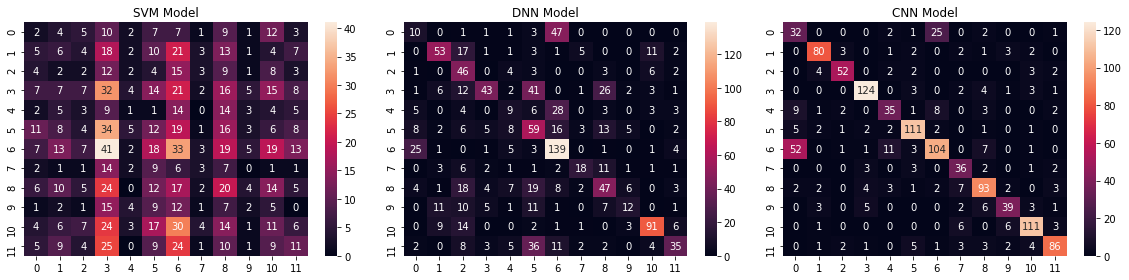

In [327]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1, title='SVM Model')
sns.heatmap(confusion_matrix(y_test, svc_pred_), annot=True, fmt='g')

ax = fig.add_subplot(1, 3, 2, title='DNN Model')
sns.heatmap(confusion_matrix(y_test_nn.argmax(axis=1), dnn_pred_.argmax(axis=1)), annot=True, fmt='g')

ax = fig.add_subplot(1, 3, 3, title='CNN Model')
sns.heatmap(confusion_matrix(y_test_cnn.argmax(axis=1), cnn_pred_.argmax(axis=1)), annot=True, fmt='g')

fig.tight_layout()
plt.show()

In [328]:
print('SVM Model Classification Report')
print(classification_report(y_test, svc_pred_))

SVM Model Classification Report
              precision    recall  f1-score   support

           0       0.04      0.03      0.03        63
           1       0.08      0.06      0.07        94
           2       0.04      0.03      0.03        65
           3       0.12      0.23      0.16       138
           4       0.04      0.02      0.02        61
           5       0.10      0.09      0.10       127
           6       0.15      0.18      0.17       180
           7       0.12      0.06      0.08        47
           8       0.13      0.17      0.15       119
           9       0.07      0.03      0.05        59
          10       0.10      0.09      0.09       127
          11       0.16      0.10      0.12       108

    accuracy                           0.11      1188
   macro avg       0.10      0.09      0.09      1188
weighted avg       0.11      0.11      0.11      1188



In [331]:
print('DNN Model Classification Report')
print(classification_report(y_test_nn.argmax(axis=1), dnn_pred_.argmax(axis=1)))

DNN Model Classification Report
              precision    recall  f1-score   support

           0       0.18      0.16      0.17        63
           1       0.62      0.56      0.59        94
           2       0.32      0.71      0.44        65
           3       0.66      0.31      0.42       138
           4       0.20      0.15      0.17        61
           5       0.32      0.46      0.38       127
           6       0.55      0.77      0.64       180
           7       0.56      0.38      0.46        47
           8       0.42      0.39      0.41       119
           9       0.41      0.20      0.27        59
          10       0.76      0.72      0.74       127
          11       0.58      0.32      0.42       108

    accuracy                           0.47      1188
   macro avg       0.47      0.43      0.42      1188
weighted avg       0.50      0.47      0.46      1188



In [332]:
print('CNN Model Classification Report')
print(classification_report(y_test_cnn.argmax(axis=1), cnn_pred_.argmax(axis=1)))

CNN Model Classification Report
              precision    recall  f1-score   support

           0       0.32      0.51      0.39        63
           1       0.85      0.85      0.85        94
           2       0.85      0.80      0.83        65
           3       0.89      0.90      0.89       138
           4       0.62      0.57      0.60        61
           5       0.84      0.87      0.86       127
           6       0.73      0.58      0.65       180
           7       0.62      0.77      0.69        47
           8       0.76      0.78      0.77       119
           9       0.74      0.66      0.70        59
          10       0.86      0.87      0.87       127
          11       0.85      0.80      0.82       108

    accuracy                           0.76      1188
   macro avg       0.74      0.75      0.74      1188
weighted avg       0.77      0.76      0.76      1188



#### Observations and Conclusion:
1. Based on the comparison of training and testing accuracy, CNN is performng the best. Although all models are getting overfit.
2. SVM model is perfoming very poorly where we have got the training accuracy of 98% while on testing we got only 11%. While on the other hand, ANN model got the training accuracy of 83% and testing accuracy of 47%.
3. Among the 3, the best performing CNN have got 99.9% training accuracy and 76%.
4. Also, based on the classification report, for SVM model, the highest precision, recall and f1-score are 0.16, 0.23 and 0.17 respectively which shows the supervised learning model is unable to learn anything for all classes which is completely a overfit model.
5. While in ANN, we can see few classes have low precision, recall and f1 score but for few classes, the score is more than 50%. Hence we can conclude that ANN is performing better than SVM model.
6. Whereas CNN is performing the best with compare to SVM and ANN. As we can see in confusion matrix, most of the classes have predicted accurately and have got the accuracy of 76%.
7. Also, the precision, recall and f1 score for most of the classes is above 75%. Although, CNN is performing poorly where we have less image to train the network. The classes having more than 100 images, CNN is able to learn and provide the good result.
8. Hence we can conclude that CNN is the best performing model for the provided use case and available dataset.
9. Furthermore, the accuracy can be improved by creating more sample images from the available images using data augmentation technique. ImageDataGenerator is such method available in Keras which can be used on the available images and by applying flip, zoom, shift, rotation, brightness kind of techniques on images to create new image dataset and this dataset can be used to train the model. 

### Storing the best model

There are 2 methods using which we can store the weights. 
1. By using the save_weights method available directly in keras.
2. By using pickle library.

In [487]:
# Saving weights
cnn_model.save('best_model.h5')

In [486]:
# Using pickle
import pickle
pickle.dump(cnn_model.get_weights(), open('best_weight.pkl', 'wb'))

### Predicting the class for image in Prediction Folder

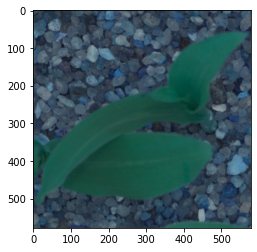

In [346]:
test_img = cv2.imread('Dataset - Prediction/Prediction/Predict.png')

plt.imshow(test_img)

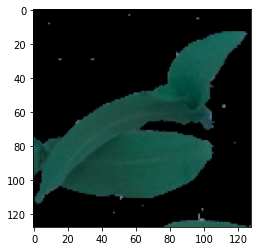

In [347]:
# Preprocessing the image - Extracting the plant from the background
test_img = extract_plant(test_img)
test_img = cv2.resize(test_img, (128, 128))
plt.imshow(test_img)

In [349]:
test_img = test_img.reshape(1, 128, 128, 3)

In [488]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

In [489]:
predict = best_model.predict(test_img)

In [490]:
encoder.inverse_transform(predict.argmax(axis=1))

array(['Maize'], dtype='<U25')

#### Observations & Conclusion:
The imported image is classified as 'Maize' based on the best trained model.

### Testing the model on the test dataset and creating submission.csv file

In [375]:
input_data = []
file_names = []
for i in os.listdir('Dataset/test/'):
    img = cv2.imread('Dataset/test/{}'.format(i))
    img = extract_plant(img)
    img = cv2.resize(img, (128, 128))
    input_data.append(img)
    file_names.append(i)

In [376]:
input_data = np.asarray(input_data)
print('The shape of input data for prediction:', input_data.shape)

The shape of input data for prediction: (794, 128, 128, 3)


In [377]:
predict = cnn_model.predict(input_data)

In [387]:
submission = pd.DataFrame(file_names, columns=['file'])
submission['species'] = encoder.inverse_transform(predict.argmax(axis=1))

In [389]:
submission.to_csv('Submission 1.csv', index=False)

## Kaggle Submission
The best model (using CNN) prediction submitted in Kaggle for evaluation

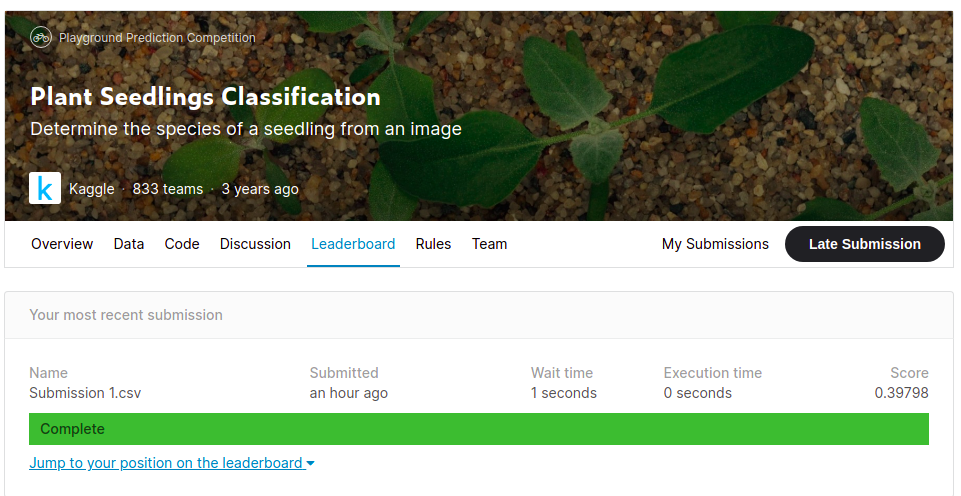

Note: The accuracy can be further improved by using Transfer Learning and using data augmentation technique to identify the images more accurately.
___

# CNN out performs DNN and Supervised Learning on images dataset

Images are consists of pixels which are atomic elements of a digital image and color channels (Generally RGB) which leads to very high number of features. In order to work on images, it is extremely important to extract the important features from these images.

CNN uses convolution process which is adding each element of the image to its local neighbors, weighted by the kernel. Convolutional uses different kernels for different feature extraction like edge detection, sharpen, blurring etc. Then the resultant features will be passed with lesser dimension compared to the original image data to Fully connected layers to predict output as shown in the below figure.

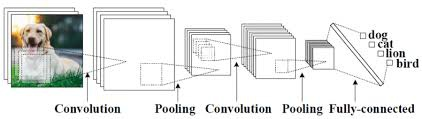

By performing the convolution operations, the dimensionality of the data shrinks significantly large. Hence, the number of parameters to be learned decreases. Hence, the network complexity decreases which leads to less chances of overfitting and it take advantage of local spatial coherence in the input, which allow them to have fewer weights as some parameters are shared.

<br>

In the case of deep neural networks, each neuron in a given layer is fully connected to all the neurons in the previous layer as you can see in the below figure.

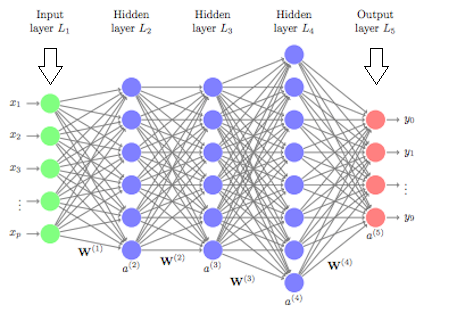

Because of these large number of connections the number of parameters to be learned increases. As the number of parameters increases, the network becomes more complex. This more complexity of the network leads to overfitting. Also, as 2 dimensional images need to be converted into 1 dimensional, due to which it is unable to capture the sequential information like edges, color, etc.

Unlike CNN and ANN, supervised learning consider only works based on the pattern identified in the dataset. Same as ANN, for supervised learning also needs the data to be converted to 1 dimensional and we can consider supervised learning algorithm is as same as ANN with just 1 neuron. So supervised learning is unable to capture any data and neither able to learn from the images. If we provide the same image which was used in training itself, if we apply some padding to the image, supervised learning going to treat that image entirely different way.

___

# Automobile
## Build AI image classifier data based on input images

A brand research company wants to understand which cars or car manufacturers are popular in a certain area of the city or locality. Company has a team which takes pictures of the cars randomly through the day. Using this the company wants to set up an automation which can classify the make of the car once the
picture has been given as an input.

### Extracting the data from zip file

In [491]:
from zipfile import ZipFile

with ZipFile('Dataset - Images.zip', 'r') as file:
    file.extractall('Automobile')

### Visualizing the images

In [510]:
print('Images present in the folder:', len(os.listdir('Automobile/Images/')))

Images present in the folder: 15


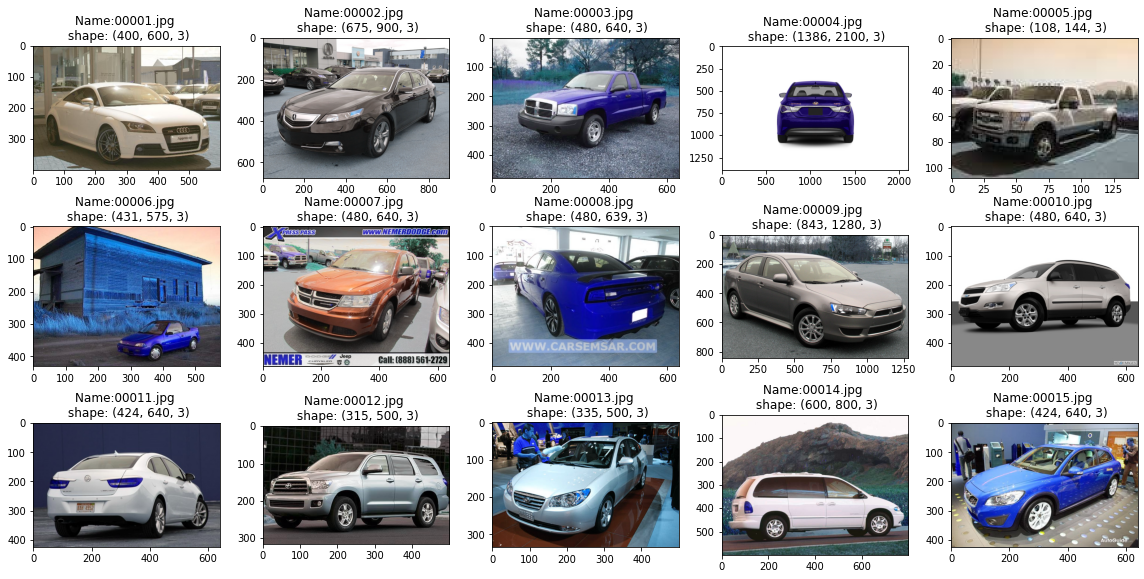

In [515]:
rows = 3
columns = 5

fig = plt.figure(figsize=(16, 8))
index = 0

for i in sorted(os.listdir('Automobile/Images/')):
    index += 1
    img = cv2.imread('Automobile/Images/{}'.format(i))
    ax = fig.add_subplot(rows, columns, index, title='Name:{} \n shape: {}'.format(i, img.shape))
    plt.imshow(img)

fig.tight_layout()
plt.show()

#### Observations:
1. There are 15 images present in the folder.
2. There are no label available for the images.
3. The images are of different size.
4. Also we can see, apart from car being in focus, there are variations in the background and advertisement content marked in images.
5. As images are few so we will try to manually label the images as per below image.

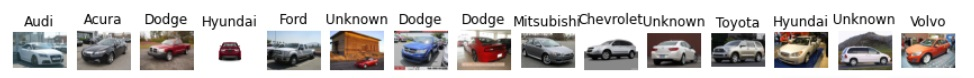

### Features based on the above images

In [536]:
images_names = sorted(os.listdir('Automobile/Images/'))
car_make = ['Audi', 'Acura', 'Dodge', 'Hyundai', 'Ford', 'Unknown', 'Dodge', 'Dodge', 'Mitsubushi', 'Chevrolet', 'Unknown', 'Toyota', 'Hyundai', 'Unknown', 'Volvo']
car_color = ['White', 'Black', 'Blue', 'Blue', 'White', 'Blue', 'Red', 'Blue', 'Gray', 'Silver', 'White', 'Silver', 'White', 'White', 'Blue']
car_type = ['Coupe', 'Sedan', 'Truck', 'Sedan', 'Truck', 'Unknown', 'SUV', 'Sedan', 'Sedan', 'SUV', 'Sedan', 'SUV', 'Sedan', 'SUV', 'Sedan']
car_seating = [2, 4, 2, 4, 2, 2, 6, 4, 4, 6, 4, 6, 4, 6, 4]

In [538]:
car_dataset = pd.DataFrame({
    'Image': images_names,
    'Make': car_make,
    'Color': car_color,
    'Type': car_type,
    'Seating': car_seating
})

In [539]:
car_dataset

Image        Make   Color     Type  Seating
0   00001.jpg        Audi   White    Coupe        2
1   00002.jpg       Acura   Black    Sedan        4
2   00003.jpg       Dodge    Blue    Truck        2
3   00004.jpg     Hyundai    Blue    Sedan        4
4   00005.jpg        Ford   White    Truck        2
5   00006.jpg     Unknown    Blue  Unknown        2
6   00007.jpg       Dodge     Red      SUV        6
7   00008.jpg       Dodge    Blue    Sedan        4
8   00009.jpg  Mitsubushi    Gray    Sedan        4
9   00010.jpg   Chevrolet  Silver      SUV        6
10  00011.jpg     Unknown   White    Sedan        4
11  00012.jpg      Toyota  Silver      SUV        6
12  00013.jpg     Hyundai   White    Sedan        4
13  00014.jpg     Unknown   White      SUV        6
14  00015.jpg       Volvo    Blue    Sedan        4

In [540]:
car_dataset.to_csv('Automobile/vehicles.csv', index=False)

### Loading the dataset

In [541]:
dataset = pd.read_csv('Automobile/vehicles.csv')

In [544]:
dataset.head(15)

Image        Make   Color     Type  Seating
0   00001.jpg        Audi   White    Coupe        2
1   00002.jpg       Acura   Black    Sedan        4
2   00003.jpg       Dodge    Blue    Truck        2
3   00004.jpg     Hyundai    Blue    Sedan        4
4   00005.jpg        Ford   White    Truck        2
5   00006.jpg     Unknown    Blue  Unknown        2
6   00007.jpg       Dodge     Red      SUV        6
7   00008.jpg       Dodge    Blue    Sedan        4
8   00009.jpg  Mitsubushi    Gray    Sedan        4
9   00010.jpg   Chevrolet  Silver      SUV        6
10  00011.jpg     Unknown   White    Sedan        4
11  00012.jpg      Toyota  Silver      SUV        6
12  00013.jpg     Hyundai   White    Sedan        4
13  00014.jpg     Unknown   White      SUV        6
14  00015.jpg       Volvo    Blue    Sedan        4

### Loading the images

In [563]:
image_dataset = []
image_name = []

for i in sorted(os.listdir('Automobile/Images/')):
    img = cv2.imread('Automobile/Images/{}'.format(i))
    img = cv2.resize(img, (128, 128))
    image_dataset.append(img)
    image_name.append(i)

### Visualizing the dataset with label

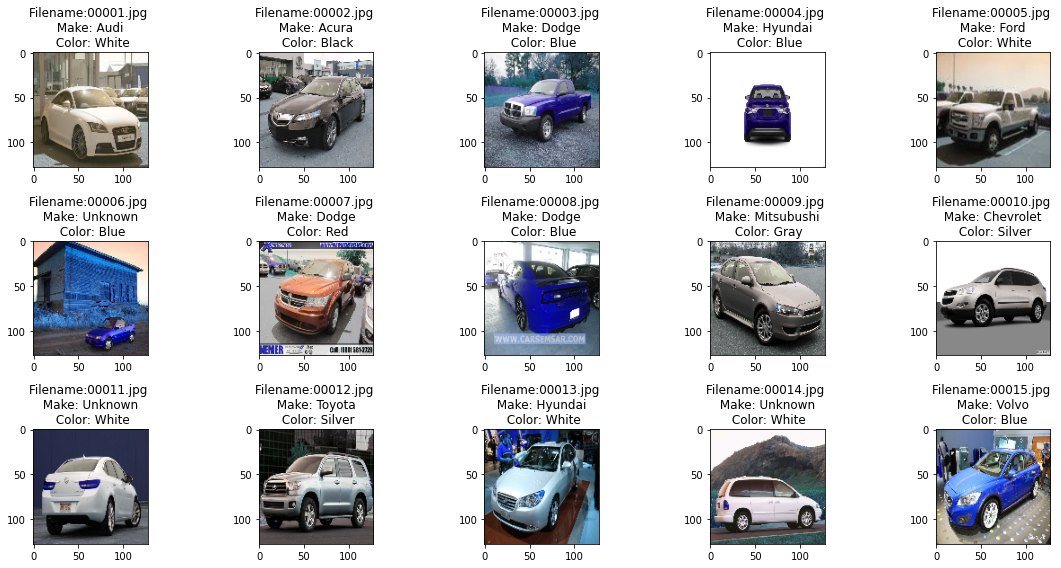

In [567]:
rows = 3
columns = 5

fig = plt.figure(figsize=(16, 8))
index = 0

for i in range(0, rows*columns):
    index += 1
    img = image_dataset[i]
    ax = fig.add_subplot(rows, columns, index, title='Filename:{} \n Make: {} \n Color: {}'.format(image_name[i], dataset.loc[i, 'Make'], dataset.loc[i, 'Color']))
    plt.imshow(img)

fig.tight_layout()
plt.show()

### Creating image dataset from the available images with its label to build classifier

For generating the image dataset, we will use ImageDataGenerator and 'Make' as the image label.

In [568]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [653]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.2, 
    rotation_range=65,
    shear_range=0.09,
    horizontal_flip=True,
    vertical_flip=True
)

image_gen_data = image_generator.flow_from_dataframe(dataset, directory='Automobile/Images/', x_col='Image', y_col='Make', class_mode="categorical", target_size=(128, 128), batch_size=128)

Found 15 validated image filenames belonging to 10 classes.


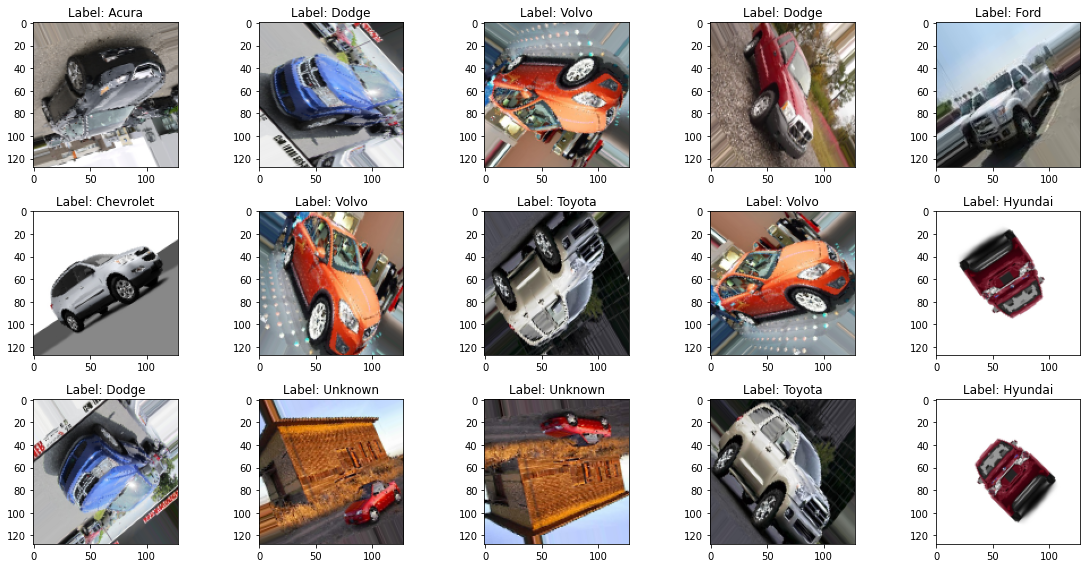

In [654]:
rows = 3
columns = 5

fig = plt.figure(figsize=(16, 8))
index = 0

for i in range(0, rows*columns):    
    index += 1
    img, label = next(image_gen_data)
    ax = fig.add_subplot(rows, columns, index, title='Label: {}'.format([key for key, value in image_gen_data.class_indices.items() if value == np.argmax(label[i])][0]))
    plt.imshow(img[i])

fig.tight_layout()
plt.show()

#### Challenges:
1. The dataset available was very small as only 15 images were present.
2. There were no labels/tags were available for classification.
3. The images which are present are of different sizes.
4. In order to tag the images, we need to visually check each images and label them accordingly.
5. As for label, we have used Make, Seating Capacity, Car Type and Color.
6. As we manually checked the images, it is a time consuming process and if there is any image missed we need verify the data accordingly.
7. Few of the cars which we not able to identify has been categorized as 'Unknown' class as we were unable to identify the logo/model of the car.
8. For building the model, the image data was not sufficient for which we have to use ImageDataGenerator for data augmentation.